In [1]:
import os
import numpy as np
import fish_net_functions as fn
import pandas as pd
import copy 
import networkx as nx
import itertools
import community
import random
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from scipy import signal
from scipy import stats
from matplotlib import colors as mcolors


from mpl_toolkits.mplot3d import axes3d

# Jupyter specific autoreloading for external functions (in case changes are made)
%load_ext autoreload
%autoreload
# %matplotlib widget

# Get initial specifications and files

In [2]:
# Define manually
#---------------------------------------------------------------------------
Fbase    = '/Users/roschkoenig/Dropbox/Research/1901 Fish2p/suite2p data'

# Specify automatically
#---------------------------------------------------------------------------
Fscripts = Fbase + os.sep + 'Scripts'
Fdata    = Fbase + os.sep + 'Data'

# Load fish data from data folder
#---------------------------------------------------------------------------
Fish  = fn.fish_net_load(Fdata)

Found 10 planes


In [3]:
fdat = fn.fish_net_regrout(Fish["Data"], fun = 'lin')   # Regress out baseline drift 
Fish.update({"Filt":fdat})


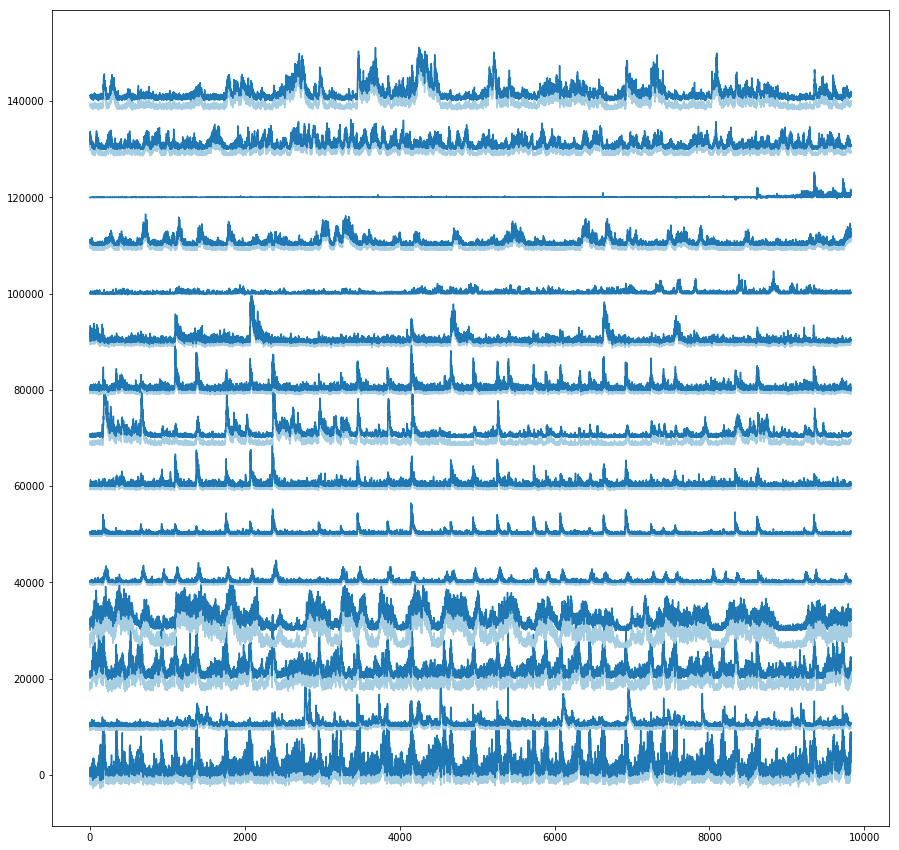

In [4]:
# Plot example outputs
#---------------------------------------------------------------------------


nplt  = 15
d     = Fish["Data"][:nplt,:]
fd    = Fish["Filt"][:nplt,:]
cm    = plt.get_cmap("Paired")

plt.figure(figsize=(15,15))
for i in range(nplt):
    plt.plot(fd[i,:] + 10000*i, c=cm(0))
    plt.plot(d[i,:] + 10000*i, c=cm(1))

# Summary statistics of resting state activity
In this section we are trying to summarise resting state activity in terms of overall distribution of activation - in particular, e.g. the size of 'avalanche activity' - activity that involves multiple, roughly spatially contiguous neurons within the same time frame. The analysis has largely been adapted from the [Sumbre lab paper in Neuron](https://www.ncbi.nlm.nih.gov/pubmed/30449656)

### _Find nearest neighbours for each individual cell_

In [5]:
# Set up nearest neighbour graph
#---------------------------------------------------------------------------
cs   = Fish["Coordinates"]
nnb  = fn.fish_net_nneigh(cs, cnt=1)
Fish["NNGraph"] = nnb

Doing row 0 of 15811
Doing row 1581 of 15811
Doing row 3162 of 15811
Doing row 4743 of 15811
Doing row 6324 of 15811
Doing row 7905 of 15811
Doing row 9486 of 15811
Doing row 11067 of 15811
Doing row 12648 of 15811
Doing row 14229 of 15811
Doing row 15810 of 15811
Done


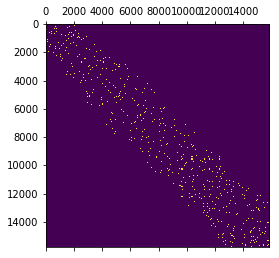

In [6]:
plt.matshow(Fish["NNGraph"])

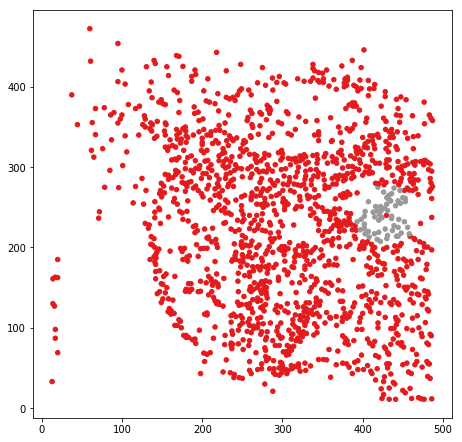

In [7]:
# Plot an illustrative example
#----------------------------------------------------------------------------------------
plane = 1

# Pull out the data from fish structure
#----------------------------------------------------------------------------------------
cs   = Fish["Coordinates"]                  # 3D array of xyz coordinates
ci   = np.where(cs[:,2] == plane)[0]        # Index of plane coordinates in long list
nnb  = Fish["NNGraph"]

# Actual plotting routines
#----------------------------------------------------------------------------------------
plt.figure(figsize = (7.5,7.5))
plt.scatter(cs[ci,0], cs[ci,1], s = 20, c = nnb[ci[109],ci], cmap = 'Set1')

### _Detect peaks in the signal_

In [17]:
# Detect peaks in ncells * ntime points data
#----------------------------------------------------------------
pks = fn.fish_net_peaks(Fish["Filt"])
Fish["Peaks"] = pks

# Set up random shuffled array for comparisonii
#----------------------------------------------------------------
rpks = copy.deepcopy(pks)
rpks = rpks.ravel()
np.random.shuffle(rpks) 
rpks = np.reshape(rpks, pks.shape)

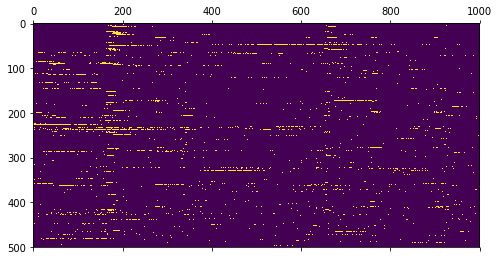

In [18]:
# Plot a section of the detected peaks
#---------------------------------------------------------------------
plt.matshow(pks[:500,:1000])

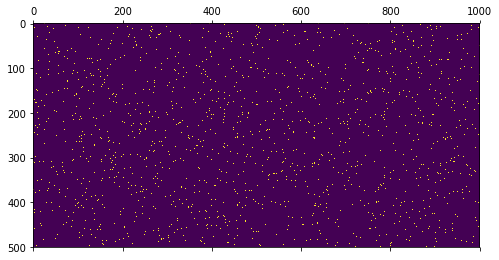

In [19]:
plt.matshow(rpks[:500,:1000])

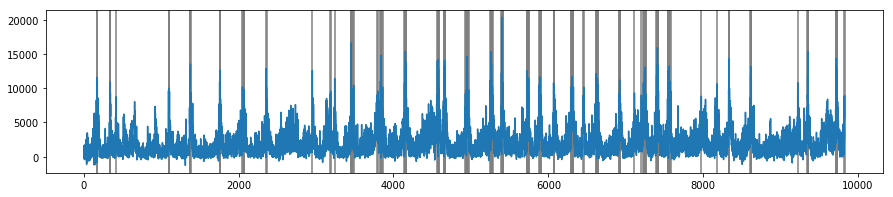

In [20]:
# Plot an illustrative example
#----------------------------------------------------------------------------------------
pks = Fish["Peaks"]

# Actual plotting routines
#----------------------------------------------------------------------------------------
plt.figure(figsize = (15,3))
for x in np.where(pks[0,:])[0]: plt.axvline(x=x, c='gray')
plt.plot(Fish["Data"][0,:])

### _Identify avalanches spreading out across immediate neighbours_

In [21]:
# Detect activity in more than 3 connected ROIs
#----------------------------------------------------------------------------
pks = Fish["Peaks"]
nnb = Fish["NNGraph"]
pkg,avsz = fn.fish_net_avalanche(pks, nnb)

# Rerun with randomised peaks
#----------------------------------------------------------------------------
rpkg,ravsz = fn.fish_net_avalanche(rpks,nnb)

Doing time point 0 of 9828
Doing time point 982 of 9828
Doing time point 1964 of 9828
Doing time point 2946 of 9828
Doing time point 3928 of 9828
Doing time point 4910 of 9828
Doing time point 5892 of 9828
Doing time point 6874 of 9828
Doing time point 7856 of 9828
Doing time point 8838 of 9828
Doing time point 9820 of 9828
Now calculating avalanche size
Doing time point 0 of 9828
Doing time point 982 of 9828
Doing time point 1964 of 9828
Doing time point 2946 of 9828
Doing time point 3928 of 9828
Doing time point 4910 of 9828
Doing time point 5892 of 9828
Doing time point 6874 of 9828
Doing time point 7856 of 9828
Doing time point 8838 of 9828
Doing time point 9820 of 9828
Now calculating avalanche size


/Users/roschkoenig/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/Users/roschkoenig/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


Text(0.5,0,'Number of coactive cells / size of avalanche')

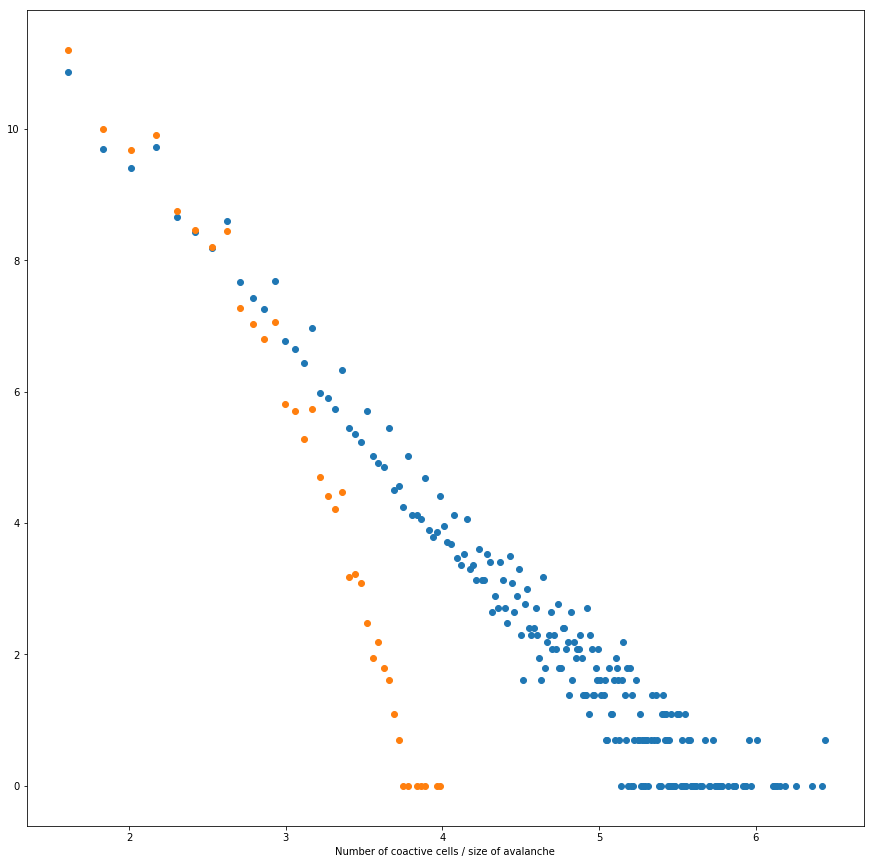

In [24]:
# Plot log-log histogram
#-----------------------------------------------------------------------------------------
a  = avsz[avsz >= 5]
ra = ravsz[ravsz >= 5]
ls = np.linspace(np.min(a), np.max(a), 500)

ah  = np.histogram(a, bins = ls)
rah = np.histogram(ra, bins = ls)

plt.figure(figsize=(15,15))
plt.scatter(np.log(ah[1][:-1]), np.log(ah[0]))
plt.scatter(np.log(rah[1][:-1]), np.log(rah[0]))
plt.xlabel('Number of coactive cells / size of avalanche')


# Initial segmentation into spatially contiguous clusters

In [25]:
# Run k-mean clustering on x-y coordinates to get spatially contiguous seed clusters
#-----------------------------------------------------------------------------------------
Fish = fn.fish_net_spacek(Fish, 15)

Now working on plane 0.0 of 9.0
Now working on plane 1.0 of 9.0
Now working on plane 2.0 of 9.0
Now working on plane 3.0 of 9.0
Now working on plane 4.0 of 9.0
Now working on plane 5.0 of 9.0
Now working on plane 6.0 of 9.0
Now working on plane 7.0 of 9.0
Now working on plane 8.0 of 9.0
Now working on plane 9.0 of 9.0


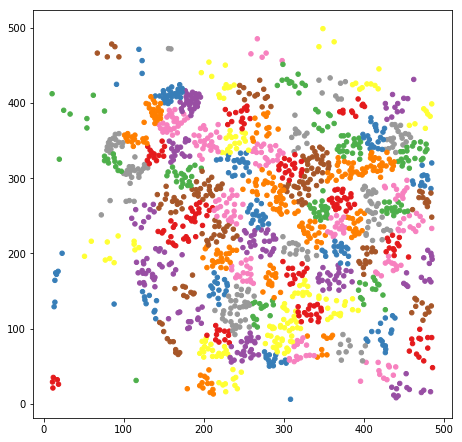

In [26]:
# Plot an illustrative example
#----------------------------------------------------------------------------------------
plane = 3

# Pull out the data from fish structure
#----------------------------------------------------------------------------------------
cs = Fish["Coordinates"]                  # 3D array of xyz coordinates
ci = Fish["Planes"][plane]["Index"]       # Index of plane coordinates in long list
ks = Fish["Planes"][plane]["Klabel"]      # Label from kmeans clustering

# Actual plotting routines
#----------------------------------------------------------------------------------------
plt.figure(figsize = (7.5,7.5))
plt.scatter(cs[ci,0], cs[ci,1], s = 20, c = ks, cmap = 'Set1')

# Further parcellate according to functional correlation structure

In [27]:
# Calculate average traces within clusters
#----------------------------------------------------------------------------------------------
d      = Fish["Data"]
l      = Fish["Klabel"]
loc    = Fish["Coordinates"]
md,ml,mloc  = fn.fish_net_average(d,l,loc)

# Pack averaged data into Fish structure
#----------------------------------------------------------------------------------------------
Kdata = {"Label":ml, "Data":md, "Coordinates":mloc}
Fish.update({"Kdata":Kdata})

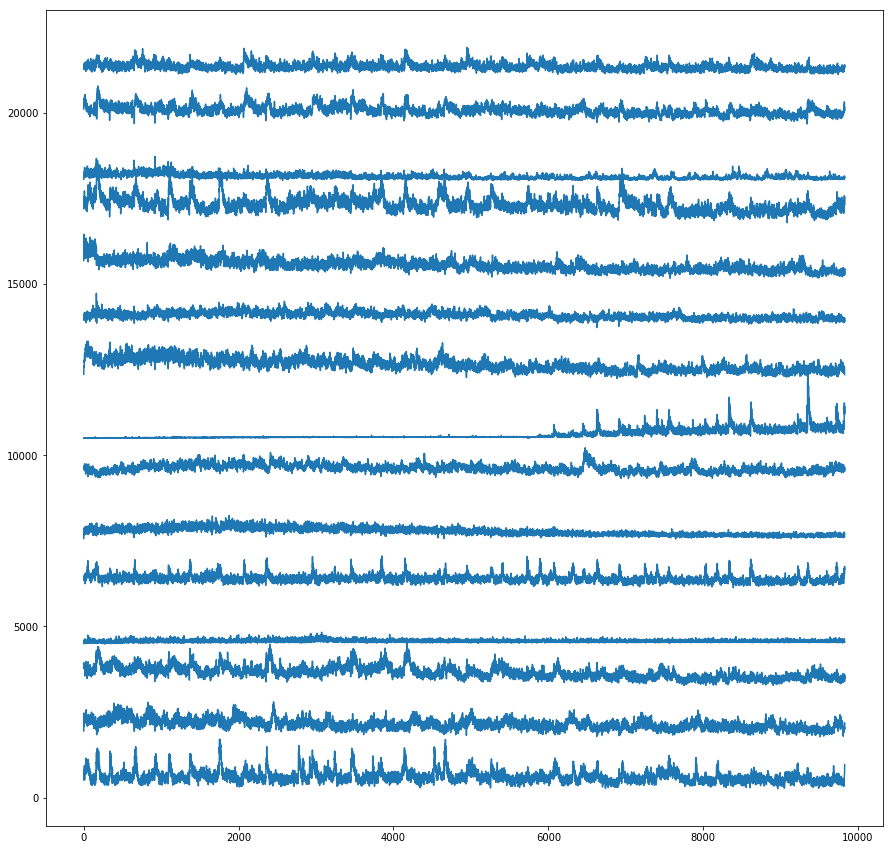

In [28]:
# Plot an example traces
#----------------------------------------------------------------------------------------------
nplt  = 15
d     = Fish["Kdata"]["Data"][:nplt,:]
cm    = plt.get_cmap("Paired")

plt.figure(figsize=(15,15))
for i in range(nplt):
    plt.plot(d[i,:] + 1500*i, c=cm(1))

### _Find functionally related clusters_

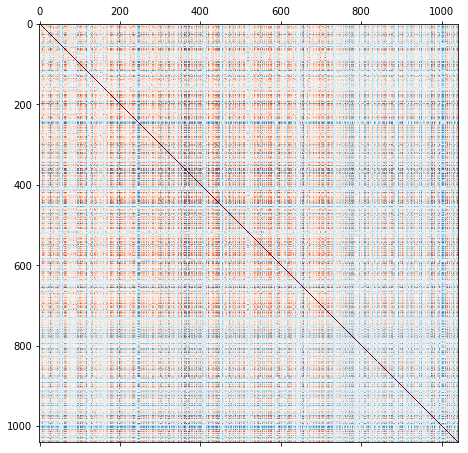

In [29]:
# Plot correlation matrix of drift corrected data
#---------------------------------------------------------------------------------
cor = np.corrcoef(Fish["Kdata"]["Data"])
plt.rc('figure', figsize=(7.5,7.5))
plt.matshow(cor, cmap='RdBu_r')

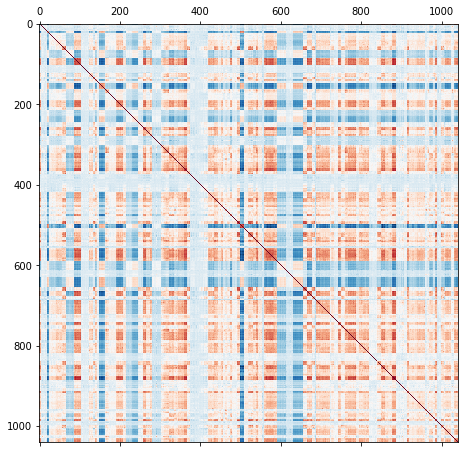

In [30]:
# Run K-means clustering on correlation matrix 
#------------------------------------------------------------------------------------
kmeans   = KMeans(n_clusters=100, random_state=0).fit(cor)
kl       = kmeans.labels_
outplot  = 'corr'       # corr or plane

# Plot an example plane
#-------------------------------------------------------------------------------------
if outplot == 'plane':
    plane = 3
    cs    = Fish["Kdata"]["Coordinates"]
    pi    = np.where(cs[:,2] == plane)[0]

    plt.figure(figsize=(5,5))
    plt.scatter(cs[pi,0], cs[pi,1], c=kl[pi], cmap = 'magma')

# Plot correlation matrix ordered by k-means cluster
#------------------------------------------------------------------------------------
if outplot == 'corr':
    klstd   = np.argsort(kl)
    scor    = cor[klstd,:]
    scor    = scor[:,klstd] 
    plt.rc('figure', figsize=(7.5,7.5))
    plt.matshow(scor,cmap='RdBu_r')

### _Split up clusters that are too spatially separate_

In [209]:
# Split up clusters according to spatial parameters
#-----------------------------------------------------------------------
cs  = Fish["Kdata"]["Coordinates"]
ps  = fn.fish_net_divconq(kl,cs)      # Parcel labelling

# Unpack to single neuron level
#-----------------------------------------------------------------------
cs = Fish["Coordinates"]
ks = Fish["Klabel"]
lb = np.zeros((cs.shape[0],1))
for i in range(cs.shape[0]): lb[i] = ps[int(ks[i])]
    
# Average within label groups
#----------------------------------------------------------------------
md,ml,mloc = fn.fish_net_average(Fish["Filt"], lb, cs)
Ps = ({"Label":ps, "Coordinates":mloc, "Data":md})
Fish.update({"Parcels":Ps})

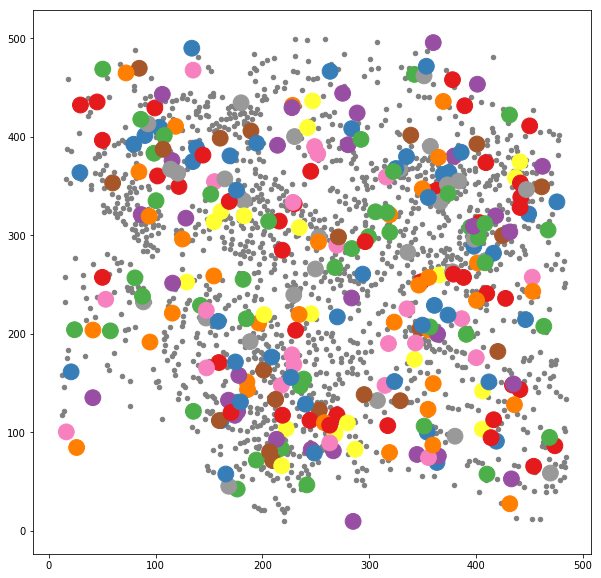

In [210]:
# Plot new categorisation
#-----------------------------------------------------------------------
fine_cs      = Fish["Coordinates"]
crse_cs      = Fish["Parcels"]["Coordinates"]
ks           = Fish["Klabel"]
fine_lb      = np.zeros((fine_cs.shape[0],1))
crse_lb      = np.zeros((crse_cs.shape[0],1))

for i in range(fine_cs.shape[0]): fine_lb[i] = ps[int(ks[i])]
for i in range(crse_cs.shape[0]): crse_lb[i] = Fish["Parcels"]["Label"][i]
    

cci    = np.where(Fish["Parcels"]["Coordinates"][:,2] == plane) 

# Actual plotting routines
#----------------------------------------------------------------------------------------
plane  = 5
fci    = Fish["Planes"][plane]["Index"]  
f, ax1 = plt.subplots(1, 1, sharey=True, figsize=(10,10))
ax1.scatter(fine_cs[fci,0], fine_cs[fci,1], s = 20, c = 'gray', cmap = 'Set1')
ax1.scatter(crse_cs[:,0], crse_cs[:,1], s = 250, c = crse_lb[:,0], cmap = 'Set1')


(286, 1000)

<Figure size 1080x720 with 0 Axes>

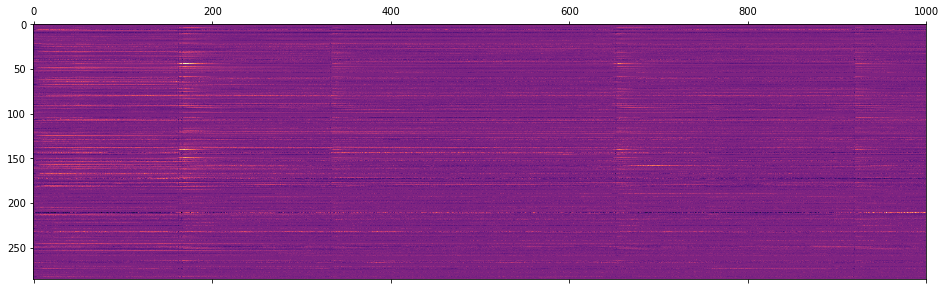

In [211]:
# Plot example module traces
#---------------------------------------------------------------------------------------
plt.figure(figsize=(15,10))
plt.matshow(Fish["Parcels"]["Data"][:400,:1000], cmap='magma')
Fish["Parcels"]["Data"][:400,:1000].shape

In [212]:
# Convert matrix into NetworkX Graph object to run module detection
#-------------------------------------------------------------------------------------
cor        = np.corrcoef(Fish["Parcels"]["Data"]); 
cor[cor < 0] = 0
G          = nx.from_numpy_array(cor)
partition  = community.best_partition(G)
M          = {"Label":np.asarray(partition.values())}
Fish.update({"Modules":M})

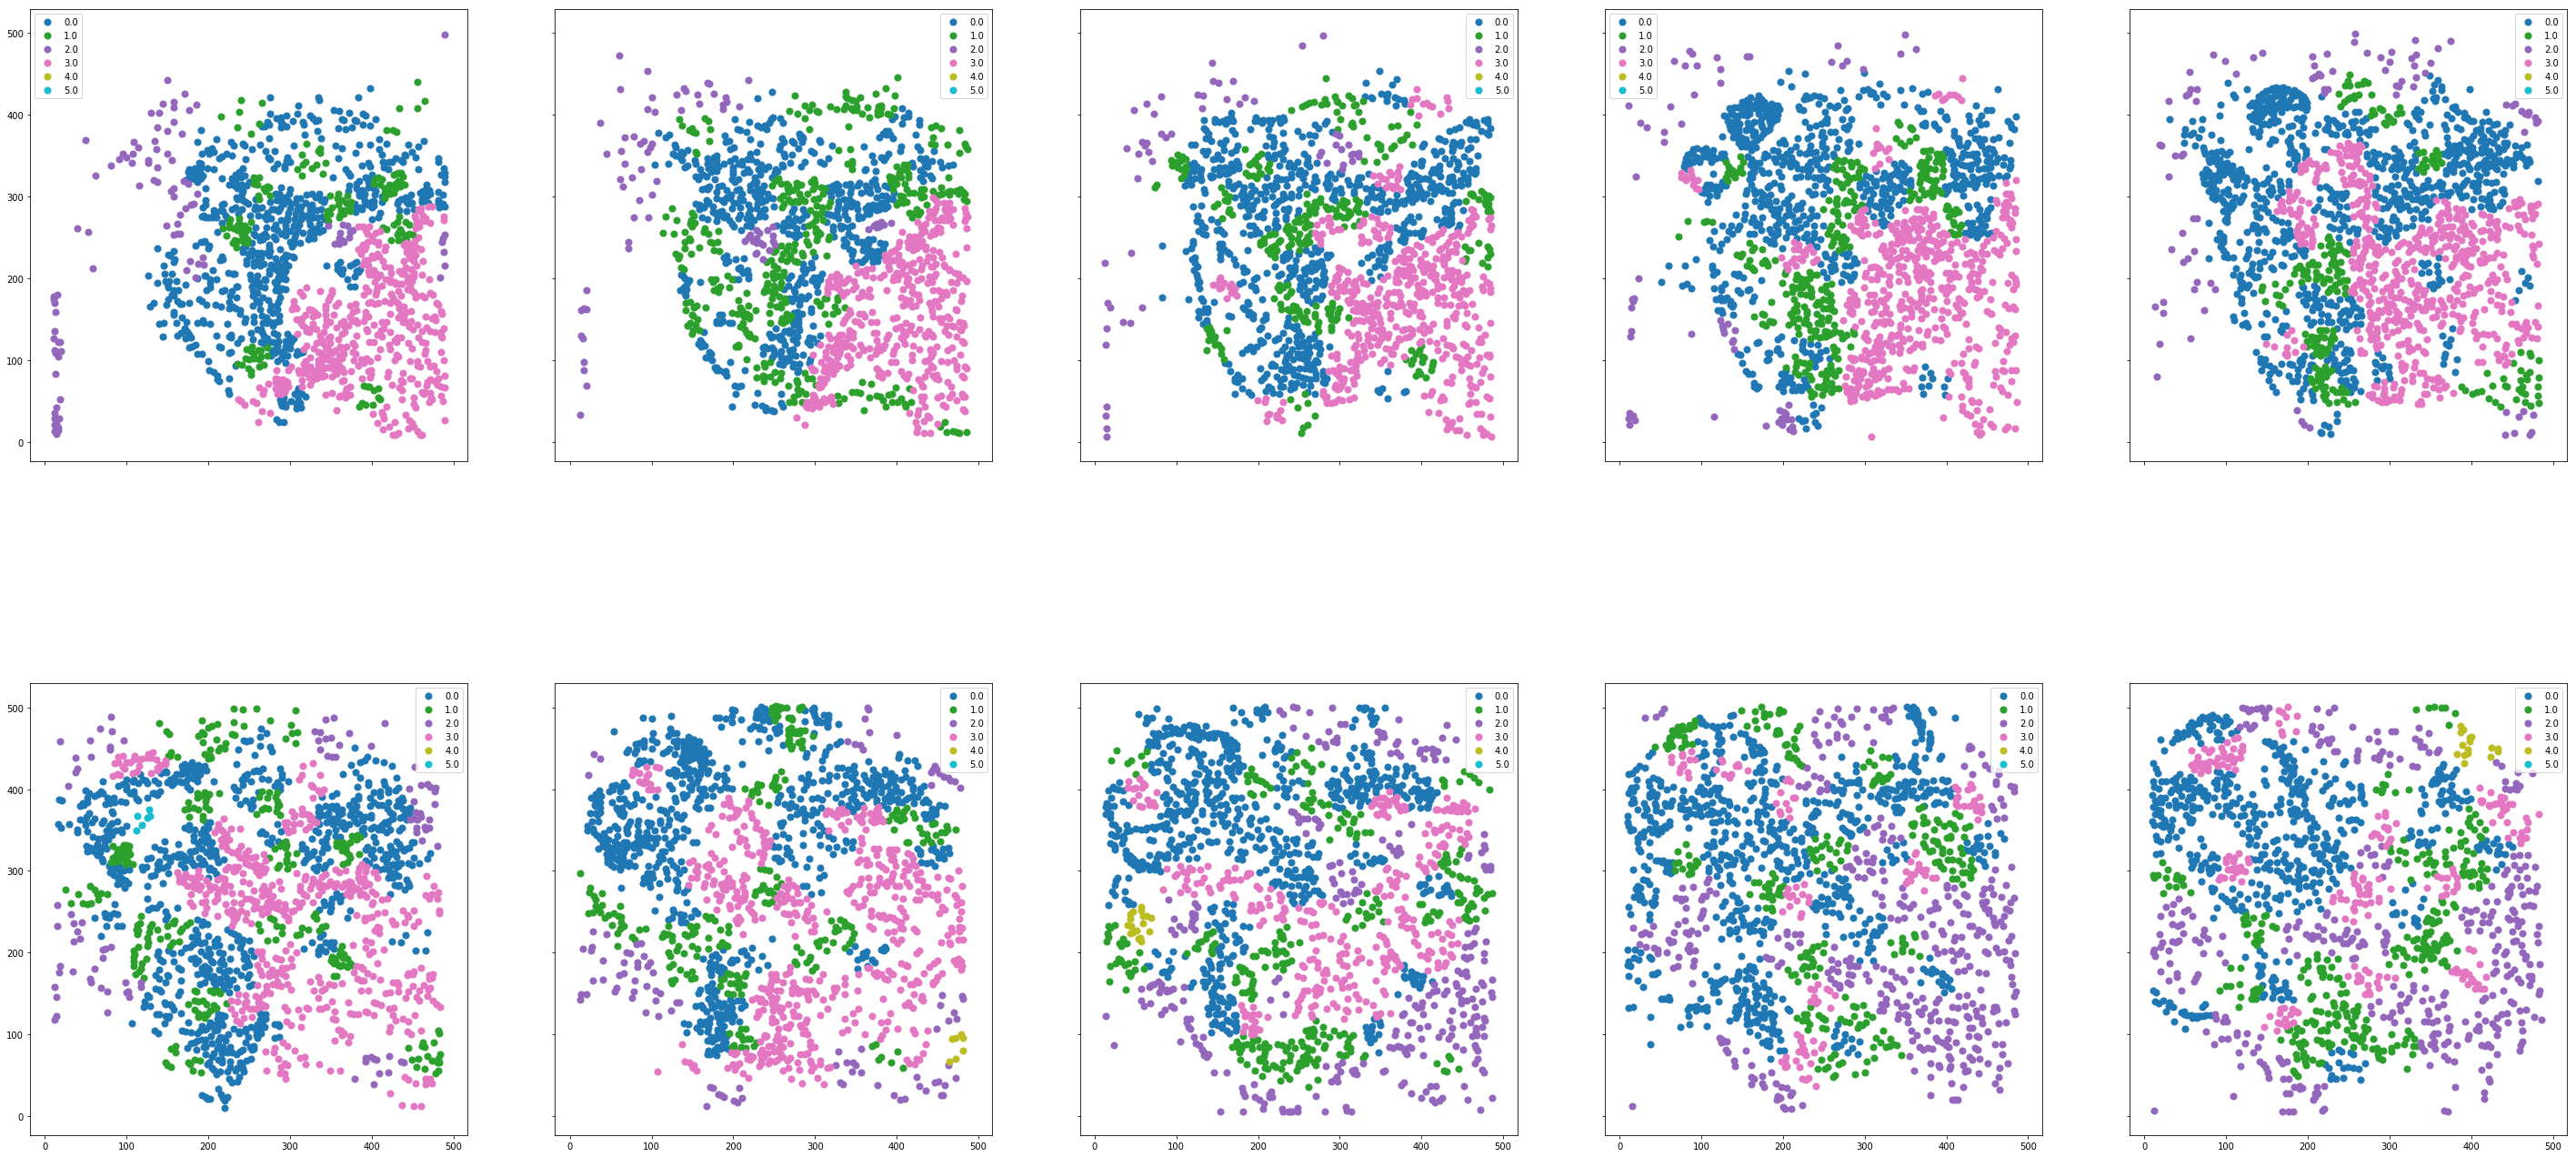

In [418]:
# Plot new categorisation
#-----------------------------------------------------------------------
c2k = np.ndarray.astype(Fish["Klabel"], 'int')            # 15811 labels in 1041 categories
k2p = np.ndarray.astype(Fish["Parcels"]["Label"], 'int')  # 1041 labels in 286 categories
p2m = np.ndarray.astype(Fish["Modules"]["Label"], 'int')  # 286 labels in 6 categories

# Assign labels
#----------------------------------------------------------------------
cs = Fish["Coordinates"]
lb = np.zeros((cs.shape[0],1))
for i in range(lb.shape[0]): lb[i] = p2m[k2p[c2k[i]]]
    
# Actual plotting routines
#----------------------------------------------------------------------------------------
f, ax = plt.subplots(2, 5, sharey=True, sharex=True, figsize=(50,25))
for p in range(10):
    plane  = p
    ci    = Fish["Planes"][plane]["Index"]  
    
    row    = int(np.floor(p/5))
    col    = int(p-5*np.floor(p/5))
    cmap   = plt.get_cmap('tab10', np.max(lb)+1)
    for l in np.unique(lb):
        li = ci[lb[ci,0] == l]
        ax[row,col].scatter(cs[li,0], cs[li,1], s = 50, c = cmap(l/np.max(lb)), label=l)
        
    ax[row,col].set_aspect('equal','box')
    ax[row,col].legend()


In [401]:
cmap(3)

(0.6509803921568628, 0.33725490196078434, 0.1568627450980392, 1.0)

In [ ]:
# Detect activity in more than 3 connected ROIs
#----------------------------------------------------------------------------
pks = Fish["Peaks"]
nnb = Fish["NNGraph"]
# pkg,avsz = fn.fish_net_avalanche(pks, nnb)

# Pull out module indices
#-----------------------------------------------------------------------
c2k = np.ndarray.astype(Fish["Klabel"], 'int')            # 15811 labels in 1041 categories
k2p = np.ndarray.astype(Fish["Parcels"]["Label"], 'int')  # 1041 labels in 286 categories
p2m = np.ndarray.astype(Fish["Modules"]["Label"], 'int')  # 286 labels in 6 categories

lb = np.zeros((cs.shape[0],1))
for i in range(lb.shape[0]): lb[i] = p2m[k2p[c2k[i]]]

A = []
for m in np.unique(p2m):
    print('Working on module ' + str(m))
    ti       = lb == m
    tnnb = nnb[ti[:,0],:]
    tnnb = tnnb[:,ti[:,0]]
    pkg,avsz = fn.fish_net_avalanche(pks[ti[:,0],:], tnnb)
    A.append({"pkg":pkg, "avsz":avsz})

Module 5 is empty


/Users/roschkoenig/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


<Figure size 1080x1080 with 0 Axes>

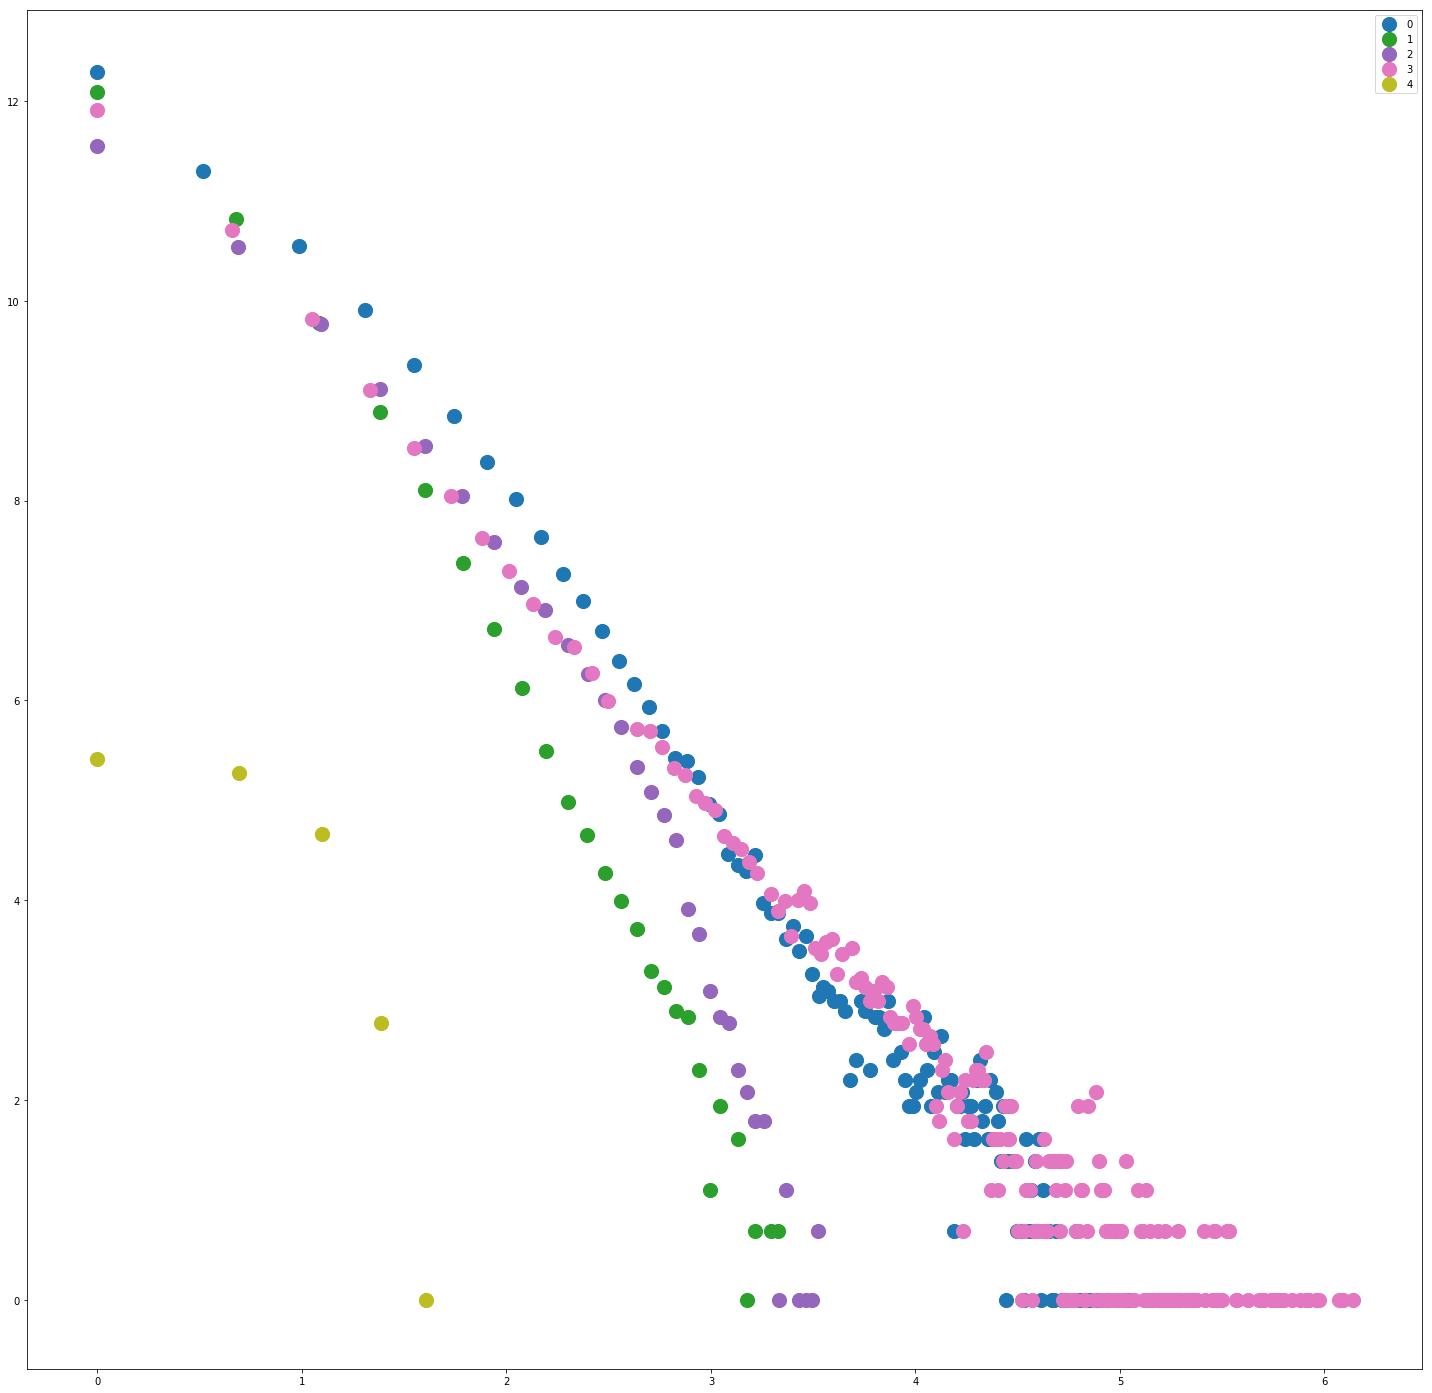

In [442]:
# Plot avalanches
#------------------------------------------------------------------------------
plt.figure(figsize=(15,15))
cmap   = plt.get_cmap('tab10', len(A))
f, ax  = plt.subplots(1,1, sharey=True, sharex=True, figsize=(25,25))

for i in range(len(A)):
    # Plot log-log histogram
    #-----------------------------------------------------------------------------------------
    if A[i]: a  = A[i]["avsz"] 
    if a.size != 0: 
        ls  = np.linspace(np.min(a), np.max(a), 500)
        ah  = np.histogram(a, bins = ls)
        ax.scatter(np.log(ah[1][:-1]), np.log(ah[0]), s = 200, c = cmap(float(i)/len(A)), label=i)
    else: 
        print('Module ' + str(i) + ' is empty')

ax.legend()


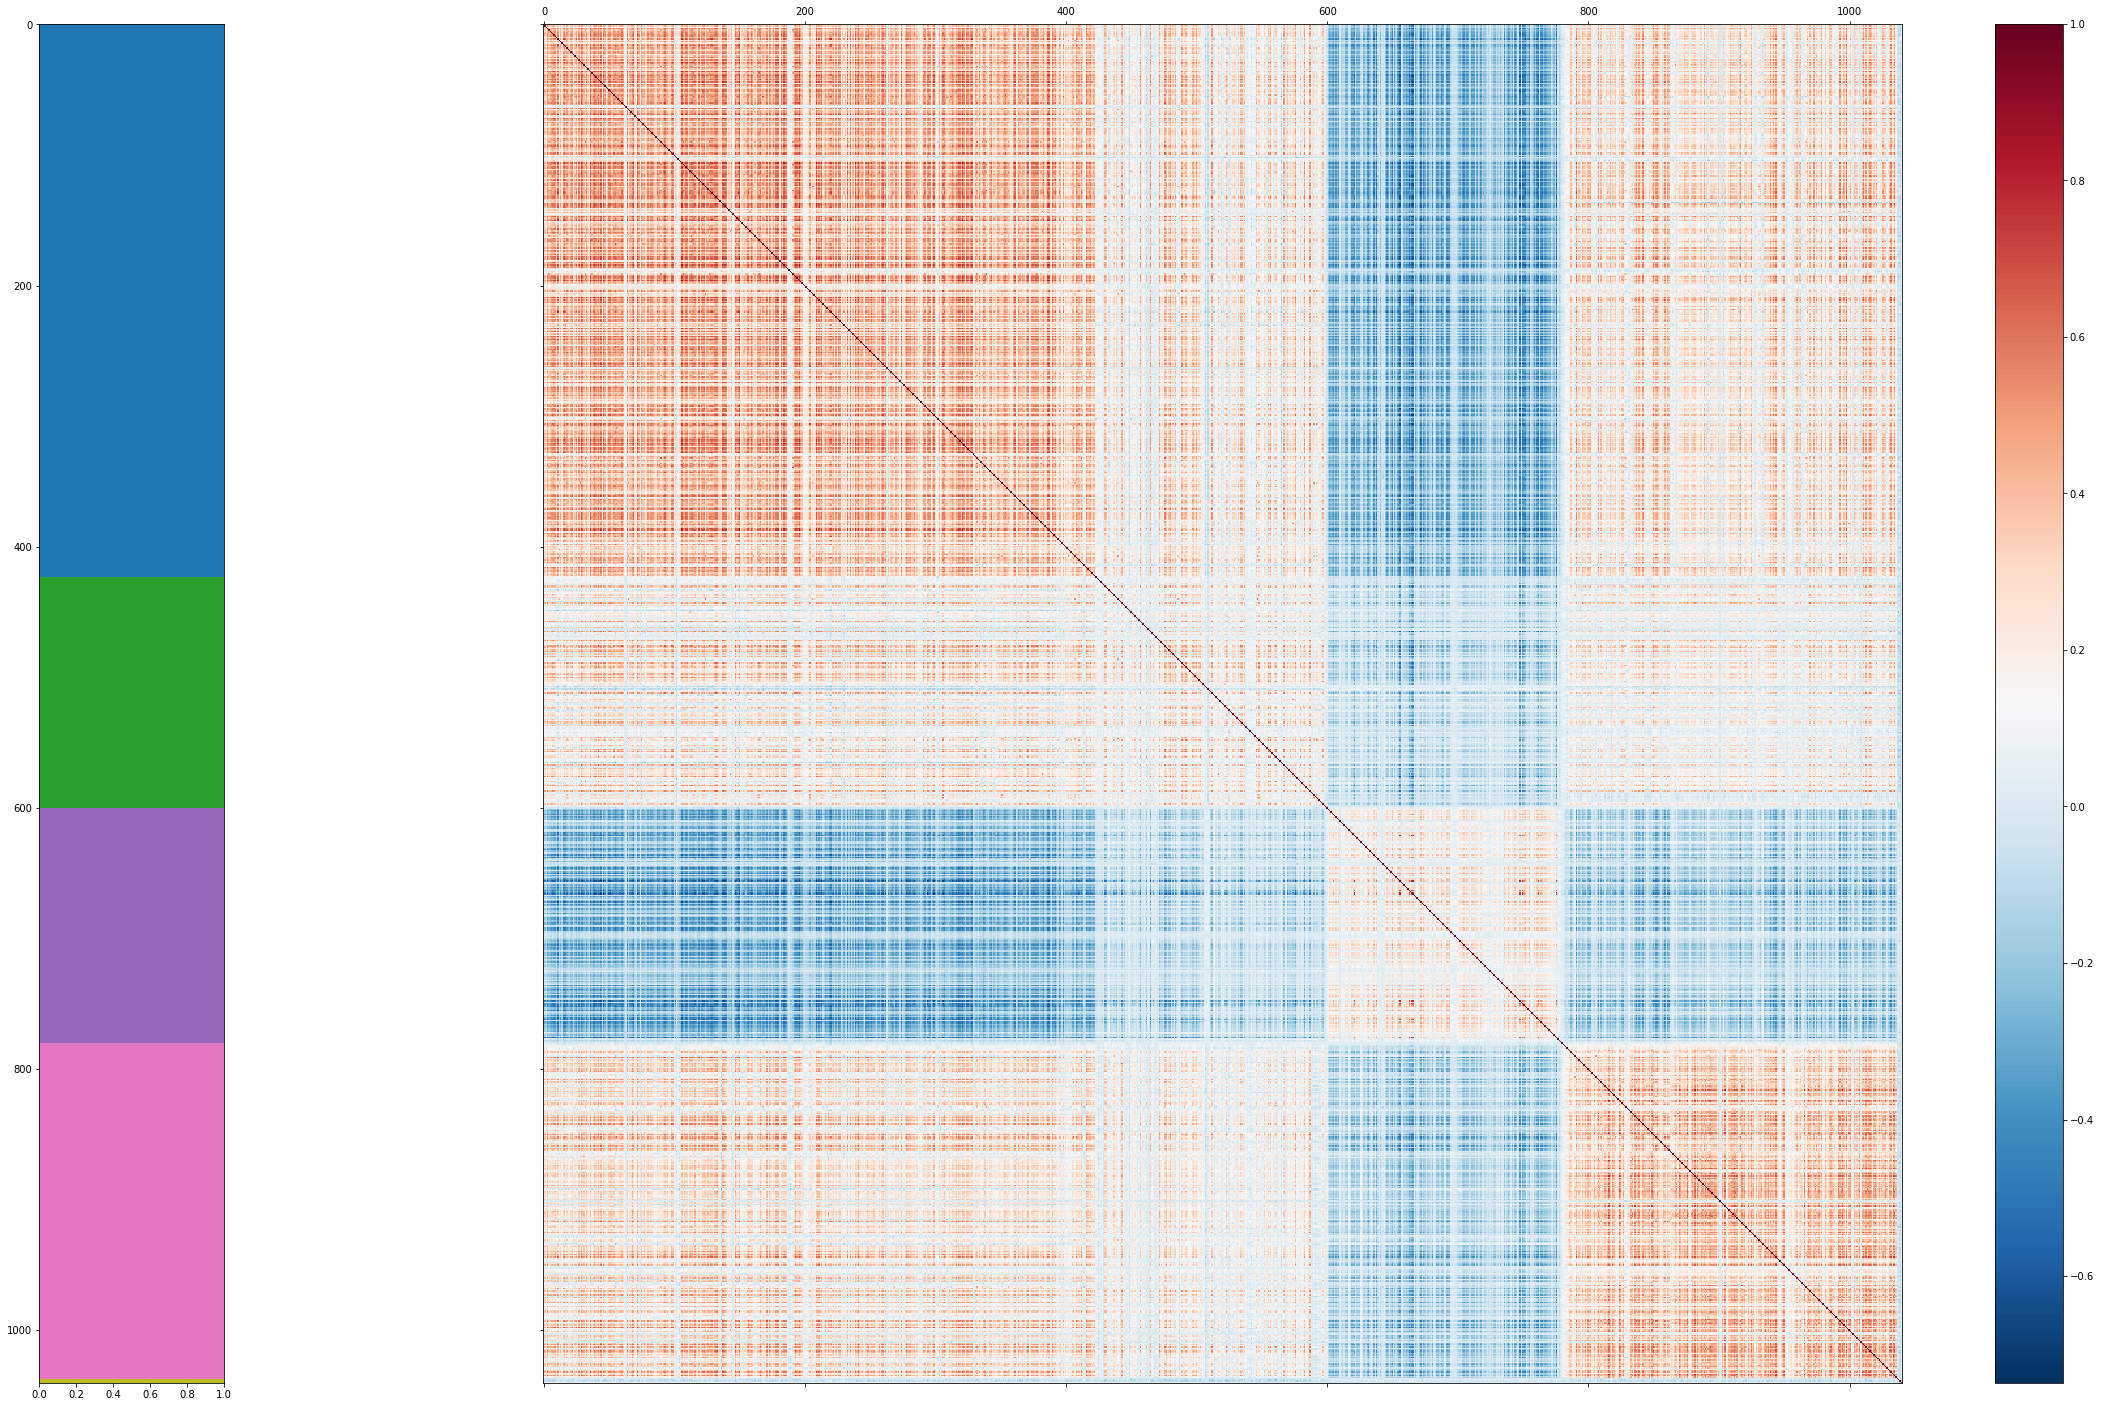

In [540]:
# Plot correlation matrix
#---------------------------------------------------------------------------------------------
cor = np.corrcoef(Fish["Kdata"]["Data"])
k2p = np.ndarray.astype(Fish["Parcels"]["Label"], 'int')  # 1041 labels in 286 categories
p2m = np.ndarray.astype(Fish["Modules"]["Label"], 'int')  # 286 labels in 6 categories
lb  = np.zeros((cor.shape[0],1))

for i in range(lb.shape[0]): lb[i] = p2m[k2p[i]]
lb = lb[:,0]

# Plot correlation matrix ordered 
#------------------------------------------------------------------------------------
f, ax   = plt.subplots(1,2, sharey=True, figsize=(40,25), gridspec_kw = {'width_ratios':[1, 10]})
klstd   = np.argsort(lb)
scor    = cor[klstd,:]
scor    = scor[:,klstd] 

cmap    = plt.get_cmap('tab10', np.max(lb) + 1)
allc    = np.flip(np.true_divide(lb[klstd],np.max(lb)), axis=0)
ally    = np.asarray(range(np.max(klstd), -1, -1))

for l in np.unique(lb):
    pl = np.where(lb[klstd] == l)[0]
    for p in pl:
        ax[0].axhline(ally[int(p)], color = cmap(allc[p]), linewidth=3)
                      
cax = ax[1].matshow(scor,cmap='RdBu_r')
f.colorbar(cax)

In [529]:
allc

array([1. , 0.8, 0.8, ..., 0. , 0. , 0. ])

In [162]:
ck

u'lightblue'

In [602]:
l

[(2, 1), (2, 2)]